In [15]:
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np
from matplotlib.lines import Line2D
PLT_CELL = 5
FIG_DIR = "/home/stephenz/stephenz/sc-causal-grn/figures/"
DATA_PATH = "../data/Synthetic_1000/dyn-SW/dyn-SW-1000-2/"

In [16]:
adata = ad.read_h5ad(DATA_PATH + "anndata.h5ad")
adata.X = adata.obsm["X_raw"]

In [17]:
# sc.pp.log1p(adata)
sc.pp.pca(adata)

In [18]:
sc.tl.tsne(adata, perplexity = 100, use_rep = "X_pca")

In [19]:
adata.obsm

AxisArrays with keys: C, J, P_dpt, P_statot, P_statot_ent, P_velo_corr, P_velo_cos, P_velo_dot, X_diffmap, X_pca, X_raw, X_tsne, v

Text(0, 0.5, 'PCA2')

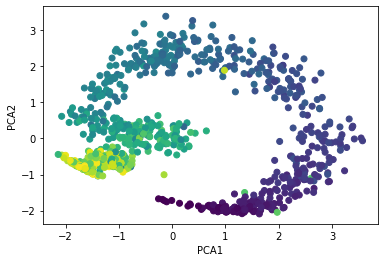

In [20]:
plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = adata.obs.dpt)
plt.xlabel("PCA1")
plt.ylabel("PCA2")

In [21]:
import networkx as nx
def prune_edges(G, q = 0.99):
    bc = nx.edge_betweenness_centrality(G)
    # bc = nx.edge_current_flow_betweenness_centrality(G)
    bc_id, bc_weights = zip(*bc.items()); bc_weights = np.array(bc_weights); bc_id = list(bc_id)
    bad_edges = (bc_weights > np.quantile(bc_weights, q))
    G_pruned = G.copy()
    G_pruned.remove_edges_from([bc_id[x] for x in np.where(bad_edges)[0]])
    assert nx.is_connected(G_pruned), "Pruning made G disconnected!"
    return G_pruned, bad_edges

G = nx.from_numpy_matrix(np.array(adata.obsp["distances"].todense()))
G_pruned, bad_edges = prune_edges(G)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

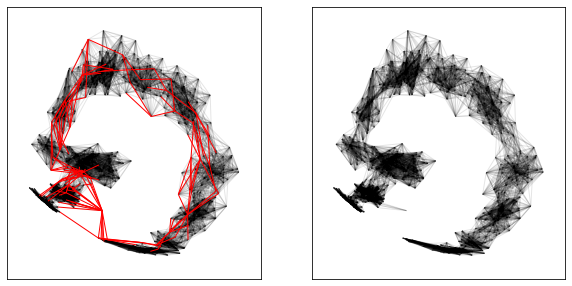

In [22]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
nx.draw_networkx_edges(G, {i : adata.obsm["X_pca"][i, 0:2] for i in range(adata.shape[0])}, edgelist = [edges[i] for i in np.where(~bad_edges)[0]], alpha = 0.1)
nx.draw_networkx_edges(G, {i : adata.obsm["X_pca"][i, 0:2] for i in range(adata.shape[0])}, edgelist = [edges[i] for i in np.where(bad_edges)[0]], edge_color = "red", alpha = 1)

plt.subplot(1, 2, 2)
nx.draw_networkx_edges(G_pruned, {i : adata.obsm["X_pca"][i, 0:2] for i in range(adata.shape[0])}, alpha = 0.1)

In [23]:
sc.tl.dpt(adata, n_branchings = 0)

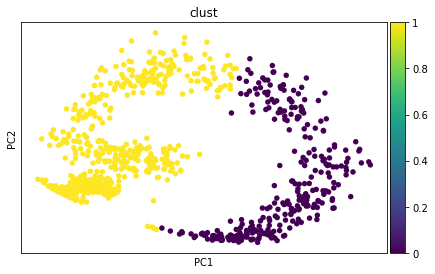

In [43]:
import sklearn as sk
from sklearn import cluster
adata.obs["clust"] = sk.cluster.KMeans(n_clusters = 2).fit_predict(adata.X)

sc.pl.scatter(adata, basis = "pca", color = "clust")

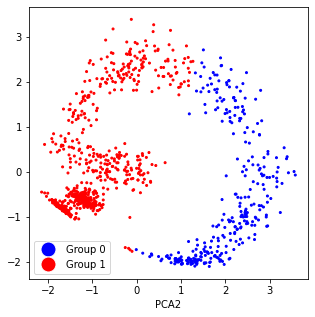

In [44]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
color_dict = {0 : "blue", 1 : "red"}
plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = [color_dict[x] for x in adata.obs.clust], s = 4)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Group 0', markerfacecolor='b', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Group 1', markerfacecolor='r', markersize=15), 
                   ]
plt.gca().legend(handles=legend_elements, loc='lower left')
plt.xlabel("PCA1")
plt.xlabel("PCA2")
plt.savefig(FIG_DIR + "sim_tsne.pdf")

In [45]:
np.save(DATA_PATH + "X_tsne2.npy", adata.obsm["X_tsne"])

In [46]:
np.save(DATA_PATH + "clusterid.npy", np.array([int(x) for x in adata.obs.clust]))